In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, Sequential, backend, callbacks

try:
    from scikeras.wrappers import KerasClassifier, KerasRegressor
except ImportError:
    !python -m pip install scikeras
    from scikeras.wrappers import KerasClassifier, KerasRegressor
  
import cv2
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(linewidth=100000, precision=3)
import sys
import pandas as pd

from skimage import data, io, filters
from skimage.transform import resize
from skimage.transform import rotate

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import datetime
from tqdm.keras import TqdmCallback

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
print(gpus)
tf.config.set_visible_devices(gpus[2:4], 'GPU')
logical_devices = tf.config.list_logical_devices('GPU')
print(logical_devices)

    
(img_train, label_train), (img_test, label_test) = tfds.as_numpy(tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    batch_size=-1,
    as_supervised=True,
))

Num GPUs Available:  4
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]


2022-03-19 22:08:57.720907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 22:08:57.721094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 22:08:57.721253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 22:08:57.721404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 22:08:57.746307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

#Using a NNet for classification

### Prelude
- The data is in the form of a 28x28 matrix that contains the greyscale pixel of an object. To use it for a Neural network, we will apply convolution to it  and then pool it into a smaller matrix as the data procesing step i.e. we will use a CNN. In addition to that, we normalize the image's pixel values to be a number between 0 and 1 by dividing by 255

In [3]:
img_train = img_train / 255
img_test = img_test / 255

#### CNN with Maxpooling

In [4]:
%%script false --no-raise-error
model = models.Sequential() # Create the model
model.add(layers.Conv2D(28, (3, 3), activation='relu', input_shape=(28, 28 , 1))) # add the first layer to convole the input matrix using a 3x3 kernal with a relu activation to prevent linearity
model.add(layers.MaxPooling2D(pool_size = (2, 2))) #pool to decrease dimension of image
model.add(layers.Conv2D(56, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size = (2, 2))) #pool
model.add(layers.Conv2D(112, (3, 3), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(112, activation='relu'))
model.add(layers.Dense(10))

In [5]:
%%script false --no-raise-error
model.summary()

In [6]:
%%script false --no-raise-error
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(img_train, label_train, epochs=10, 
                    validation_data=(img_test, label_test))

In [7]:
%%script false --no-raise-error
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(img_test,  label_test, verbose=2)

#### CNN with avgerage pooling

In [8]:
%%script false --no-raise-error
model = models.Sequential() # Create the model
model.add(layers.Conv2D(28, (3, 3), activation='relu', input_shape=(28, 28 , 1))) # add the first layer to convole the input matrix using a 3x3 kernal with a relu activation to prevent linearity
model.add(layers.AveragePooling2D(pool_size = (2, 2))) #pool to decrease dimension of image
model.add(layers.Conv2D(56, (3, 3), activation='relu'))
model.add(layers.AveragePooling2D(pool_size = (2, 2))) #pool
model.add(layers.Conv2D(112, (3, 3), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(112, activation='relu'))
model.add(layers.Dense(10))

In [9]:
%%script false --no-raise-error
model.summary()

In [10]:
%%script false --no-raise-error
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(img_train, label_train, epochs=10, 
                    validation_data=(img_test, label_test))

In [11]:
%%script false --no-raise-error
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(img_test,  label_test, verbose=2)
backend.clear_session()

### Data Augmentation

In [12]:
augmented_data = []
augmented_data_ys = []
for i,img in enumerate(img_train):
    #rotate 90 degrees
    #augmented_data.append(rotate(img,90))
    #augmented_data_ys.append(label_train[i])

    #rotate 180 degrees
    #augmented_data.append(rotate(img,180))
    #augmented_data_ys.append(label_train[i])

    #rotate 270 degrees
    #augmented_data.append(rotate(img,270))
    #augmented_data_ys.append(label_train[i])

    #flip left to right
    augmented_data.append(np.fliplr(img))
    augmented_data_ys.append(label_train[i])

In [13]:
augmented_data = np.array(augmented_data)
augmented_data_ys = np.array(augmented_data_ys)
img_train = np.concatenate((img_train,augmented_data))
print(img_train.shape)
label_train = np.concatenate((label_train,augmented_data_ys))
print(label_train.shape)

(120000, 28, 28, 1)
(120000,)


### CNN with augmented data and GridSearchCV

Currently on Layer 1, node 100
Fold 1/3, params layers = 1, nodes = 100


2022-03-19 22:09:02.179576: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Fold 2/3, params layers = 1, nodes = 100
Fold 3/3, params layers = 1, nodes = 100
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
Mean CV score + stddev: 0.8928166627883911 +/- 0.0016655085486220254


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 1s - loss: 0.5485 - accuracy: 0.8820 - 752ms/epoch - 2ms/step
Accuracy on test set: 0.8820000290870667


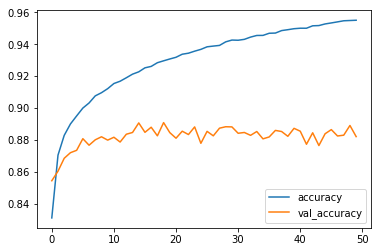

Currently on Layer 1, node 250
Fold 1/3, params layers = 1, nodes = 250
Fold 2/3, params layers = 1, nodes = 250
Fold 3/3, params layers = 1, nodes = 250
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 250)               196250    
                                                                 
 dense_1 (Dense)             (None, 10)                2510      
                                                                 
Total params: 198,760
Trainable params: 198,760
Non-trainable params: 0
_________________________________________________________________
Mean CV score + stddev: 0.9013166824976603 +/- 0.004787230683821641


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.6483 - accuracy: 0.8907 - 340ms/epoch - 1ms/step
Accuracy on test set: 0.8906999826431274


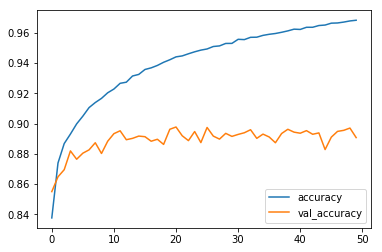

Currently on Layer 1, node 500
Fold 1/3, params layers = 1, nodes = 500
Fold 2/3, params layers = 1, nodes = 500
Fold 3/3, params layers = 1, nodes = 500
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               392500    
                                                                 
 dense_1 (Dense)             (None, 10)                5010      
                                                                 
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________
Mean CV score + stddev: 0.909208337465922 +/- 0.0012787309064239013


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.6513 - accuracy: 0.8906 - 403ms/epoch - 1ms/step
Accuracy on test set: 0.8906000256538391


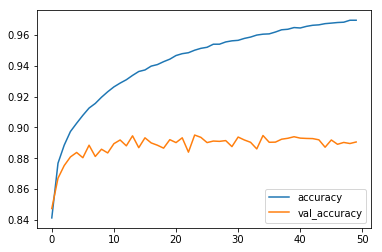

Currently on Layer 1, node 1000
Fold 1/3, params layers = 1, nodes = 1000
Fold 2/3, params layers = 1, nodes = 1000
Fold 3/3, params layers = 1, nodes = 1000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              785000    
                                                                 
 dense_1 (Dense)             (None, 10)                10010     
                                                                 
Total params: 795,010
Trainable params: 795,010
Non-trainable params: 0
_________________________________________________________________
Mean CV score + stddev: 0.9086749951044718 +/- 0.0018146308094673252


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.7376 - accuracy: 0.8919 - 328ms/epoch - 1ms/step
Accuracy on test set: 0.8919000029563904


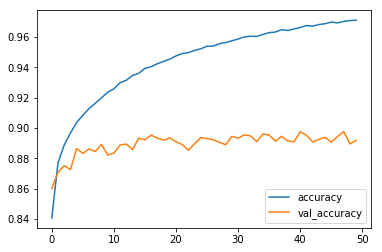

Currently on Layer 1, node 2000
Fold 1/3, params layers = 1, nodes = 2000
Fold 2/3, params layers = 1, nodes = 2000
Fold 3/3, params layers = 1, nodes = 2000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2000)              1570000   
                                                                 
 dense_1 (Dense)             (None, 10)                20010     
                                                                 
Total params: 1,590,010
Trainable params: 1,590,010
Non-trainable params: 0
_________________________________________________________________
Mean CV score + stddev: 0.9074083566665649 +/- 0.0005643349531691119


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 - 0s - loss: 0.6784 - accuracy: 0.8972 - 333ms/epoch - 1ms/step
Accuracy on test set: 0.8971999883651733


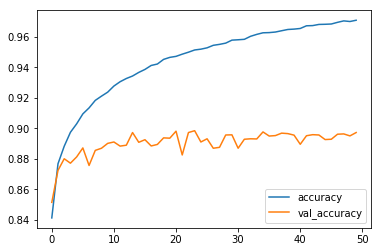

In [14]:
from IPython.display import clear_output
# Function to create model, required for KerasClassifier
def create_fnn_model( num_hidden_layers=0, num_hidden_nodes=0, summary=False, activation='relu' , optimizer='adam'):
    backend.clear_session()
    model = models.Sequential() # Create the model
    model.add(layers.Dense(num_hidden_nodes, activation=activation, input_shape=(784,)))    
    
    for i in range(1,num_hidden_layers):
        model.add(layers.Dense(num_hidden_nodes, activation=activation))
    
    model.add(layers.Dense(10))
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    if summary:
        model.summary()
    return model

hLayers = [1]
hNodes = [100, 250, 500, 1000, 2000]


num_folds = 3
num_epochs= 50

cv_results = {}
cv_results['param_layers'] = []
cv_results['param_nodes'] = []
cv_results['test_score'] = []
cv_results['mean_test_score'] = []
cv_results['std_test_score'] = []
for i in range(num_folds):
    cv_results[f'split{i}_test_score'] = []

histories = []
trainXFlat = img_train.reshape((-1,784,1))
testXFlat = img_test.reshape((-1, 784, 1))

for layer in hLayers:
    for node in hNodes:
        print(f'Currently on Layer {layer}, node {node}')
        i = 0
        kfold = KFold(num_folds, shuffle=True, random_state=1)
        accs = []
        cv_results['param_layers'].append(layer)
        cv_results['param_nodes'].append(node)
        for train_ix, test_ix in kfold.split(img_train):
            print(f'Fold {i+1}/{num_folds}, params layers = {layer}, nodes = {node}')
            model = create_fnn_model(layer, node)
            trainX, trainY = trainXFlat[train_ix], label_train[train_ix]
            testX, testY = trainXFlat[test_ix], label_train[test_ix]
            history = model.fit(trainX, trainY, epochs=num_epochs, 
                        validation_data=(testX, testY), verbose=0)
            test_loss, test_acc = model.evaluate(testX,  testY, verbose=0)
            
            cv_results[f'split{i}_test_score'].append(test_acc)
            accs.append(test_acc)
            i += 1
            del model
        cv_results['mean_test_score'].append(np.mean(accs))
        cv_results['std_test_score'].append(np.std(accs))
        model = create_fnn_model(layer, node, True)
        print(f'Mean CV score + stddev: {np.mean(accs)} +/- {np.std(accs)}')
        history = model.fit(trainXFlat, label_train, epochs=num_epochs, verbose=0, 
                            validation_data=(testXFlat, label_test), callbacks=[TqdmCallback(verbose=1)])
        test_loss, test_acc = model.evaluate(testXFlat, label_test, verbose=2)
        
        print(f'Accuracy on test set: {test_acc}')
        cv_results['test_score'].append(test_acc)
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
        plt.legend(loc="lower right")
        plt.show()
        histories.append(history)
        results_df = pd.DataFrame.from_dict(cv_results)
        results_df.to_csv("fnn15.csv")
        del model
        


In [15]:
print(cv_results)
results_df = pd.DataFrame.from_dict(cv_results)
print(results_df)
results_df.to_pickle("fnn.pkl")

{'param_layers': [1, 1, 1, 1, 1], 'param_nodes': [100, 250, 500, 1000, 2000], 'test_score': [0.8820000290870667, 0.8906999826431274, 0.8906000256538391, 0.8919000029563904, 0.8971999883651733], 'mean_test_score': [0.8928166627883911, 0.9013166824976603, 0.909208337465922, 0.9086749951044718, 0.9074083566665649], 'std_test_score': [0.0016655085486220254, 0.004787230683821641, 0.0012787309064239013, 0.0018146308094673252, 0.0005643349531691119], 'split0_test_score': [0.8946999907493591, 0.8947250247001648, 0.9081000089645386, 0.906125009059906, 0.9082000255584717], 'split1_test_score': [0.8931000232696533, 0.9032750129699707, 0.9085249900817871, 0.9101999998092651, 0.9069250226020813], 'split2_test_score': [0.8906499743461609, 0.9059500098228455, 0.9110000133514404, 0.9096999764442444, 0.9071000218391418]}
   param_layers  param_nodes  test_score  mean_test_score  std_test_score  \
0             1          100      0.8820         0.892817        0.001666   
1             1          250  

In [16]:
%%script false --no-raise-error
# Function to create model, required for KerasClassifier
def create_model( activation='relu' , optimizer='adam'):
    backend.clear_session()
    model = models.Sequential() # Create the model
    model.add(layers.Conv2D(28, (3, 3), activation='relu', input_shape=(28, 28 , 1))) # add the first layer to convole the input matrix using a 3x3 kernal with a relu activation to prevent linearity
    model.add(layers.MaxPooling2D(pool_size = (2, 2))) #pool to decrease dimension of image
    model.add(layers.Conv2D(56, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size = (2, 2))) #pool
    model.add(layers.Conv2D(112, (3, 3), activation='relu'))


    model.add(layers.Flatten())
    model.add(layers.Dense(112, activation=activation))
    model.add(layers.Dense(10))
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #model.summary()
    return model

model = KerasClassifier(model=create_model, activation='relu' , optimizer='adam' ,verbose=0)
# define the grid search parameters
#activation = ['relu', 'tanh', 'sigmoid']
optimizer = ['SGD', 'Adagrad',  'Adam']
#convnet are sensitive to batch_size and epochs so do grid search on those too
#batch_size = [5, 10, 15] #cant try more due to limited ram
#epochs = [10, 20, 30]
#param_grid = dict( activation=activation, optimizer=optimizer , epochs=epochs)
param_grid = dict( optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=5, verbose=10)
print(grid)

grid_result = grid.fit(img_train, label_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [17]:
%%script false --no-raise-error
print(grid.best_params_)
print(grid.best_index_)
print(grid.best_score_)
results_df = pd.DataFrame.from_dict(grid.cv_results_)
print(results_df)
results_df.to_pickle("cnn.pkl")